# Домашее задание 3. Неопределенность оптимального портфеля. Оптимизация CVaR.  
Выполнили Пасманик Ирина, Шарибжанова Диана 19ПМИ1



### Импорт библиотек и скачивание данных

In [1]:
!pip install yfinance > /dev/null

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import math
import scipy
import scipy.stats
import datetime
from scipy.spatial.distance import cityblock
from cvxopt import matrix, solvers
from scipy.optimize import minimize
from IPython.display import clear_output
from numpy import inf

In [3]:
data = pd.read_csv('/content/drive/MyDrive/FOR/data.csv')
data = data.drop(columns = ['Low', 'High', 'Open', 'Close', 'Volume'])

In [4]:
all_tickers = list(set(data['Name'])) # creation of data tickers list
all_tickers.sort()
# all_tickers

In [5]:
# доходность портфеля
def calc_portfolio_return(x, means):
    return float(np.matmul(x, means.to_numpy()))

# риск портфеля
def calc_portfolio_volatility(x, cov_matrix):
    sigma_sq = float(np.matmul(np.matmul(x, cov_matrix.to_numpy()), x.T))
    return sigma_sq**0.5

# выборочные средние 
def calc_sample_means(returns):
    tickers = returns.columns
    sample_means = pd.DataFrame(columns = ['Sample mean (E)'], index = tickers)
    for ticker in tickers:
        mean = np.mean(returns[ticker])
        sample_means['Sample mean (E)'][ticker] = mean
    return sample_means

# матрица выборочных ковариаций
def calc_sample_cov(returns, sample_means, verbose=True):
    tickers = returns.columns
    sample_cov = pd.DataFrame(columns = tickers, index = tickers)
    status_count = 0
    for ticker1 in tickers:    
        if verbose:
            status_count += 1
            clear_output()
            print(f"{status_count}/{len(tickers)}")

        for ticker2 in tickers:
            sum_ = 0
            N = returns[ticker2].shape[0] # количество наблюдений
            for i in range(N):
                sum_ += (returns[ticker1][i] - float(sample_means.loc[ticker1])) * (returns[ticker2][i] - float(sample_means.loc[ticker2]))

            sample_cov[ticker1][ticker2] = sum_ / (N)
    return sample_cov

# относительная ошибка в норме Manhattan (cityblock)
def calc_relative_cityblock_error(vec_true, vec_pred):
    return cityblock(vec_true, vec_pred)/np.linalg.norm(vec_true, ord=1)

### **Подготовка.** 

#### Выберите на рынке 20 активов (N=20). По наблюдениям за  год оцените математические ожидания доходностей и матрицу ковариаций доходностей (используйте выборочную матрицу ковариаций).
#### Найденные вектор средних и матрица ковариаций будут далее использованы в экспериментах как «истинные» вектор E=(E1, E2, …, EN) и матрица ковариаций (σi,j). Убедитесь, что матрица ковариаций невырожденная (если она близка к вырожденной, то измените состав активов). 

Выберем 20 активов по коэффициенту Шарпа.

In [6]:
adj_close = pd.DataFrame() # adjusted closing price
adj_close = data
adj_close = (adj_close.assign(idx=adj_close.groupby('Name').cumcount())
                 .pivot_table(index='Date', columns='Name', 
                              values='Adj Close', aggfunc='sum'))
adj_close.reset_index(level=0, inplace=True)
adj_close = adj_close.loc[:, :all_tickers[-1]:]

adj_close = adj_close.dropna(axis=1, how='any') # revome missing values
all_tickers = list(adj_close.columns)[1:]

In [7]:
log_returns = pd.DataFrame()
log_returns['Date'] = adj_close['Date']

days = len(log_returns['Date'])
for ticker in all_tickers:
    for i in range(1, days):
        log_returns.loc[i, ticker] = np.log(adj_close.loc[i, ticker]/adj_close.loc[i-1, ticker])

log_returns = log_returns.drop([0])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


In [8]:
means = pd.DataFrame(columns=['mean'], index=all_tickers)
stds = pd.DataFrame(columns=['std'], index=all_tickers)

for ticker in all_tickers:
    mean = np.mean(log_returns[ticker])
    std = np.std(log_returns[ticker])
    means['mean'][ticker] = mean
    stds['std'][ticker] = std

In [9]:
sharpe_ratios100 = pd.DataFrame(means['mean'] * stds['std']**(-1), columns=['Sharpe ratio'], index=means.index)
sharpe_ratios20 = sharpe_ratios100.sort_values(by=['Sharpe ratio'], ascending=False)[0:20]
tickers = list(sharpe_ratios20.index)

means = means.loc[tickers]
stds = stds.loc[tickers]

print(tickers)

['MWY', 'GAW', 'EAT', 'THRG', 'PPH', 'VEIL', 'ARR', 'EWI', 'IIT', 'RSW', 'ESCT', 'EMG', 'SSPG', 'BGS', 'HSL', 'JEDT', 'SDP', 'MTE', 'TRY', 'PHI']


In [10]:
cov = pd.DataFrame(columns=tickers, index=tickers)

count = 0
for ticker_1 in tickers:
  count += 1
  for ticker_2 in tickers:
      summ = 0
      N = log_returns[ticker_2].shape[0]
      for i in range(1,N+1):
          summ += (log_returns[ticker_1][i] - float(means.loc[ticker_1])) * (log_returns[ticker_2][i] - float(means.loc[ticker_2]))
      cov[ticker_1][ticker_2] = summ / N

In [11]:
det = np.linalg.det(cov.to_numpy(dtype=float))
if det == 0:
    print("Матрица вырождена", det)
else:
    print("Матрица невырождена, det =", det)
    
cond = np.linalg.cond(cov.to_numpy(dtype=float))
print("Число обусловленности =", cond)

Матрица невырождена, det = 2.4754234549166564e-86
Число обусловленности = 114.39466801250784


### Задание 1. Истинный оптимальный портфель в модели Марковица с заданным отношением к риску.

Задана константа b. Решите задачу оптимизации

$$ \begin{cases}  
    -E(x) + b\sigma(x) \rightarrow  min \\
    \sum x_i = 1 \\ 
    x_i > 0 \quad \forall i
\end{cases} $$


(т.е. найдите оптимальный портфель с отношением к риску, равным b). Найдите и зафиксируйте веса портфеля и значение целевой функции.

Здесь 

$$E(x)= E_1x_1+E_2x_2+…+E_Nx_N,$$

$\sigma^2(x)=\sum\sum \sigma_{i, j} x_ix_j$

Комментарий: использовать solver задач оптимизации для общих целевых функций, так как $\sigma(x)= \sqrt{\sum\sum \sigma_{i, j} x_ix_j}$


#### *Примечание*:
Константа b подобрана таким образом, что истинный оптимальный CVaR портфель совпадает с истинным оптимальным портфелем п.1. Значение константы смотри в упражнениях к теме
 
$ b = \frac{1}{\sqrt{2\pi}}\frac{1}{(1-\beta)}\exp{(\frac{-(\phi^{-1}(\beta))^2}{2}})$

 
Найдем константу $b$

In [12]:
beta = 0.95
b = 1/(((2*math.pi)**0.5)*(1 - beta)) * math.exp(-((scipy.stats.norm.ppf(beta))**2)/2)
print(f"b = {b}")

b = 2.0627128075074257


In [13]:
def calc_utility_function(x, means, cov_mat, b):
    return -calc_portfolio_return(x, means) + b * calc_portfolio_volatility(x, cov_mat)

def find_optimal_portfolio(objective_function, args, n_stocks, decimals=4, short_sales=False):
    x_initial = np.random.random(n_stocks)
    x_initial = x_initial/np.sum(x_initial) # normilization
    x_initial = np.array(x_initial)
        
    # bounds
    constraints = [{'type': 'eq',
                    'fun': lambda x: x.sum() - 1.0
                   }]
    x_bounds = []
    if short_sales:
        for i in range(n_stocks):
            x_bounds.append((None, None))
    else:
        for i in range(n_stocks):
            x_bounds.append((0, 1))        
  
    result = minimize(objective_function,
                      x_initial, 
                      args=args,
                      method='SLSQP', 
                      constraints=constraints,
                      bounds=x_bounds, 
                      options={'maxiter':1000, 'disp': False},
                      tol=1e-15 
                    )
    if result.success:
        return np.around(result.x, decimals=decimals), result.fun
    else:
        print("Couldn't find minimum")
        return

In [14]:
x_opt, utility_function_opt = find_optimal_portfolio(calc_utility_function, 
                                                     (means, cov, b), 
                                                     n_stocks=means.shape[0], 
                                                     decimals=3, 
                                                     short_sales=False)

In [15]:
x_opt

array([0.529, 0.013, 0.049, 0.079, 0.033, 0.015, 0.206, 0.   , 0.   ,
       0.   , 0.   , 0.009, 0.011, 0.   , 0.   , 0.   , 0.   , 0.02 ,
       0.037, 0.   ])

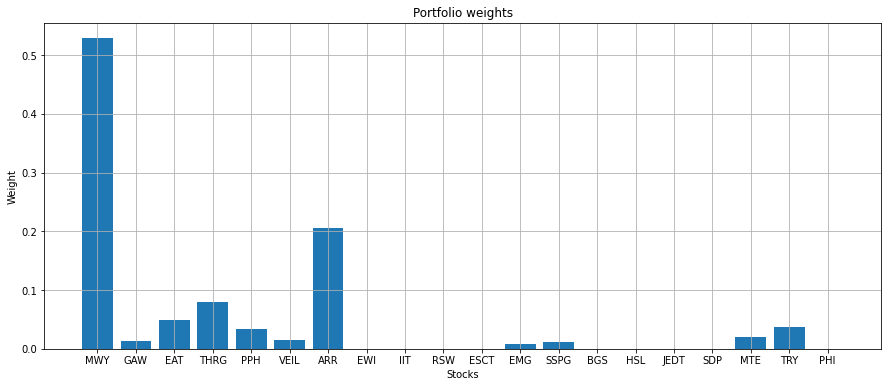

In [16]:
plt.figure(figsize=(15,6))
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.bar(tickers, x_opt)
plt.grid()
plt.title('Portfolio weights')
plt.show()

### Задание 2. Оценка неопределенности оптимального портфеля в модели Марковица с заданным отношением к риску.

#### 2.1
Задайте число наблюдений $T=30$. С помощью генератора многомерного нормального распределения создайте выборку размера $Т$ из нормального распределения с вектором математических ожиданий $E=(E_1, E_2, …, E_N)$ и матрицей ковариаций $\sigma_{i, j}$.

In [17]:
T = 30
np.random.seed(47)
log_returns_30 = np.random.multivariate_normal(means.to_numpy(dtype=float).T[0], cov.to_numpy(dtype=float), size=T) # генератор многомерного нормального распределения
log_returns_30 = pd.DataFrame(data = log_returns_30, columns=tickers)
# log_returns_30

#### 2.2 
По построенной выборке сделайте оценку $E_{est}$ вектора математических ожиданий и оценку $\sigma_{est(i, j)}$ матрицы ковариаций. 

In [ ]:
means_30 = calc_sample_means(log_returns_30) # E_est
cov_30 = calc_sample_cov(log_returns_30, means_30) # sigma_est

#### 2.3 
Используя эти оценки решите задачу оптимизации

$\begin{cases}  
    -E_{est}(x) + b\sigma_{est}(x) \rightarrow  min \\
    \sum x_i = 1 \\ 
    x_i \ge 0 \quad \forall i
\end{cases}$

Здесь 

$E_{est}(x)= E_{est1}x_1+ E_{est2}x_2+…+ E_{estN}x_N ,$ 

$\sigma_{est}^2(x) =\sum\sum \sigma_{est (i, j)} x_ix_j$

(т.е. найдите выборочный оптимальный портфель с отношением к риску, равным b). Найдите и зафиксируйте веса портфеля и значение целевой функции.


In [21]:
x_opt_30, utility_function_opt_30 = find_optimal_portfolio(calc_utility_function, 
                                                          (means_30, cov_30, b), 
                                                          n_stocks=means_30.shape[0], 
                                                          decimals=3, 
                                                          short_sales=False)

In [22]:
x_opt_30

array([0.146, 0.048, 0.003, 0.   , 0.049, 0.   , 0.248, 0.   , 0.061,
       0.003, 0.   , 0.003, 0.146, 0.   , 0.037, 0.   , 0.063, 0.   ,
       0.194, 0.   ])

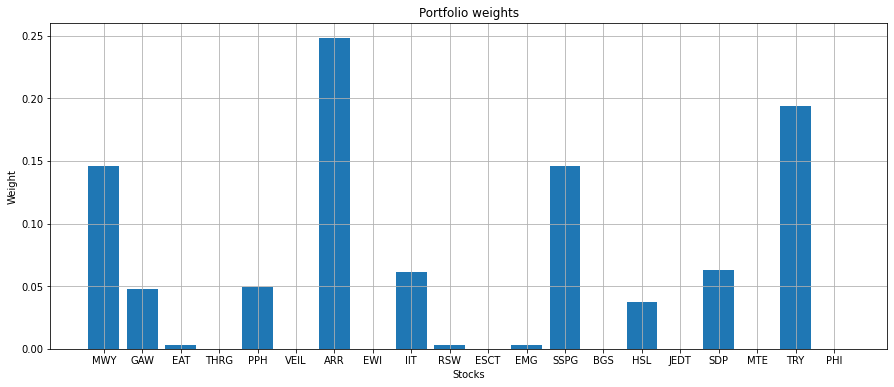

In [23]:
plt.figure(figsize=(15,6))
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.bar(tickers, x_opt_30)
plt.grid()
plt.title('Portfolio weights')
plt.show()

#### 2.4 
Сравните два портфеля: истинный (п.1) и выборочный (п.2.3). Оцените относительную ошибку в определении весов портфеля в норме Manhattan (L1 норма Минковского). Сделайте выводы. Сделайте сравнение в системе координат $(\sigma, E)$. 

Из графиков видно, что в "истинном" портфеле наиболее важным является актив MWY (занимает более половины). А в случае с выборочным портфелем,было выделено 4 основных актива, которые имеют примерно одинаковый вес: ARR(0.25), TRY(0.2), MWY(0.15) и SSPG(0.15).

In [24]:
x_opt_return = calc_portfolio_return(x_opt, means)
x_opt_volatility = calc_portfolio_volatility(x_opt, cov)

x_opt_30_return = calc_portfolio_return(x_opt_30, means)
x_opt_30_volatility = calc_portfolio_volatility(x_opt_30, cov)

Относительная ошибка в норме Manhattan составляет: 1.0969030969030968


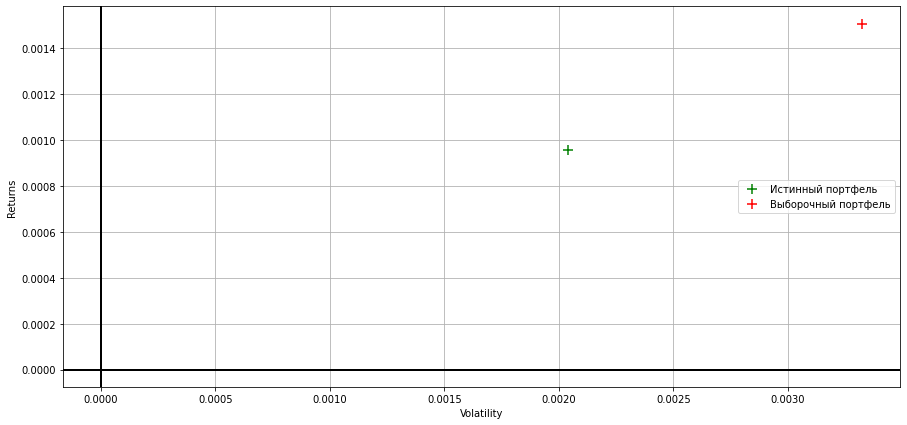

In [25]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

ax.scatter(x_opt_volatility, x_opt_return, color="g", marker="+", s=100, label="Истинный портфель")    
ax.scatter(x_opt_30_volatility, x_opt_30_return, color="r", marker="+", s=100, label="Выборочный портфель")       

ax.set_xlabel("Volatility")
ax.set_ylabel("Returns")
ax.grid()
ax.legend()
fig.show()

print("Относительная ошибка в норме Manhattan составляет:", calc_relative_cityblock_error(x_opt, x_opt_30))

#### 2.5
Повторите эксперимент $S=40$ раз и оцените среднюю относительную ошибку по $S$ повторениям эксперимента. Сделайте выводы.  Сделайте сравнение в системе координат $(\sigma, E)$. 

20/20
Средняя относительная ошибка по 40 повторениям эксперимента: 0.6867132867132867


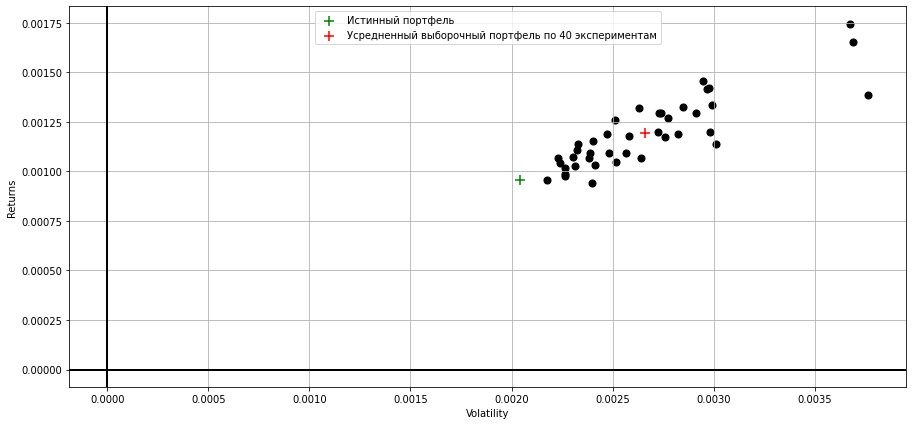

In [26]:
S = 40

# plot
fig, ax = plt.subplots(figsize=(15, 7))
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')
ax.scatter(x_opt_volatility, x_opt_return, color="g", marker="+", s=100, label="Истинный портфель")      

# main loop
x_opt_list = [] # оптимальные портфели для каждого из S экспериментов 
rel_errors = [] # относительные ошибки
x_opt_40_returns = [] # доходность каждого из S портфелей
x_opt_40_volatilities = [] # риск каждого из S портфелей

for i in range(S):
    # random log returns
    log_returns_40 = np.random.multivariate_normal(means.to_numpy(dtype=float).T[0], cov.to_numpy(dtype=float), size=T)
    log_returns_40 = pd.DataFrame(data = log_returns_40, columns=tickers)
    
    # calculate sample means and sample covariance matrix
    means_40 = calc_sample_means(log_returns_40)
    cov_40 = calc_sample_cov(log_returns_40, means_40, verbose=True)
    
    # find optimal portfolio
    x_opt_40, utility_function_40_sample = find_optimal_portfolio(calc_utility_function, 
                                                     (means_40, cov_40, b), 
                                                     n_stocks=means_40.shape[0], 
                                                     decimals=3, 
                                                     short_sales=False)
    
    # calculate and store the value of error
    rel_errors.append(calc_relative_cityblock_error(x_opt, x_opt_40)) 
    
    # store return and volatility of an optimal portfolio
    x_opt_40_returns.append(calc_portfolio_return(x_opt_40, means))
    x_opt_40_volatilities.append(calc_portfolio_volatility(x_opt_40, cov))
    
    x_opt_list.append(np.array(x_opt_40))    
    
    # plot
    ax.scatter(x_opt_40_volatilities[i], x_opt_40_returns[i], 
           color="black", marker="o", s=50)
    
x_opt_list = np.array(x_opt_list)

# plot
ax.scatter(np.array(x_opt_40_volatilities).mean(), np.array(x_opt_40_returns).mean(), 
           color="red", marker="+", s=100, label=f"Усредненный выборочный портфель по {S} экспериментам")

ax.set_xlabel("Volatility")
ax.set_ylabel("Returns")
ax.grid()
ax.legend()
fig.show()

first_error = np.array(rel_errors).mean()
print(f"Средняя относительная ошибка по {S} повторениям эксперимента: {np.array(rel_errors).mean()}")


#### 2.6  
Предположите, что нам известны точные значения математических ожиданий $E=(E_1, E_2, …, E_N)$. Повторите пп. 2.2-2.5. используя оценку только матрицы ковариаций (т.е. решайте задачу оптимизации 

$\begin{cases}  
    -E(x) + b\sigma_{est}(x) \rightarrow  min \\
    \sum x_i = 1 \\ 
    x_i \ge 0 \quad \forall i
\end{cases}$

Здесь 

$E(x)= E_1x_1+E_2x_2+…+E_Nx_N, $

$\sigma_{est}^2(x) =\sum\sum \sigma_{est (i, j)} x_ix_j$ )

Сравните точность этих портфелей и портфелей п.2.3


In [27]:
x_opt_30_ist, utility_function_opt_30_ist = find_optimal_portfolio(calc_utility_function, 
                                                          (means, cov_30, b), 
                                                          n_stocks=means_30.shape[0], 
                                                          decimals=3, 
                                                          short_sales=False)

In [28]:
x_opt_30_ist

array([0.222, 0.051, 0.014, 0.   , 0.064, 0.   , 0.178, 0.   , 0.042,
       0.   , 0.   , 0.   , 0.135, 0.   , 0.035, 0.   , 0.049, 0.   ,
       0.21 , 0.   ])

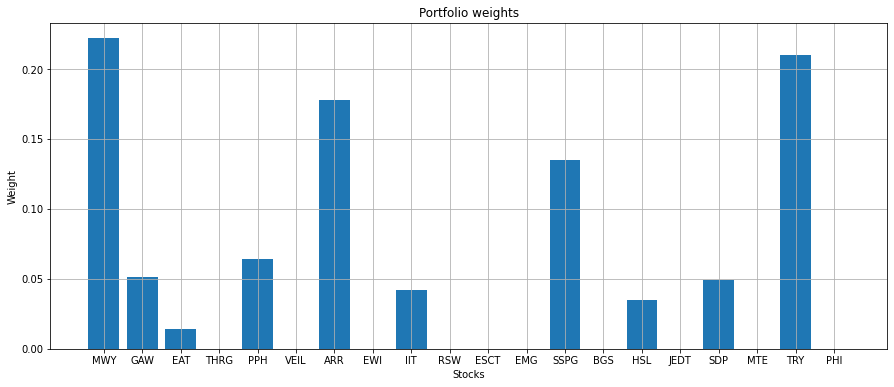

In [29]:
plt.figure(figsize=(15,6))
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.bar(tickers, x_opt_30_ist)
plt.grid()
plt.title('Portfolio weights')
plt.show()

Как в выборочном портфеле с истинной доходностью, так и в истинном портфеле наибольший вес имеет MWY. Однако в целом по распределению весов выборочный портфель с истинной доходностью больше похож на выборочный портфель, чем на истинный (те же 4 актива имеют наибольшие веса).

Относительная ошибка в норме Manhattan между истинным портфелем и выборочным портфелем: 1.0969030969030968
Относительная ошибка в норме Manhattan между истинным портфелем и выборочным портфелем с истинной доходностью: 0.984015984015984


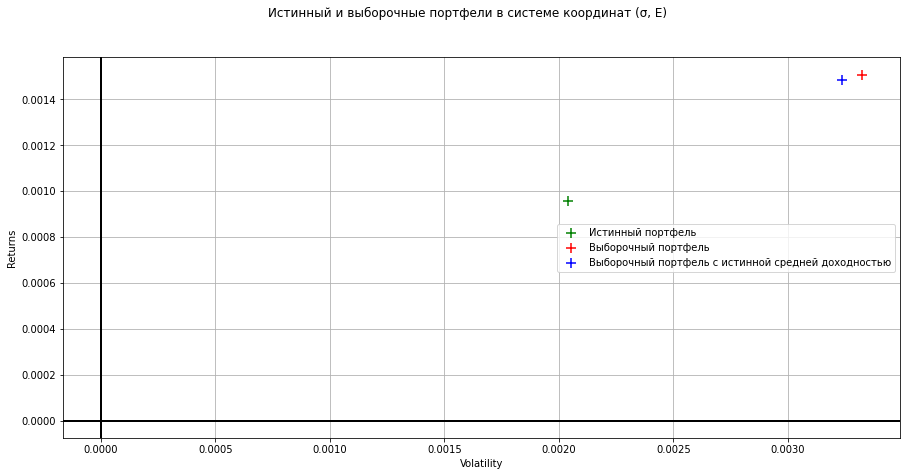

In [30]:
# расчеты доходности и риска
x_opt_30_return_ist = calc_portfolio_return(x_opt_30_ist, means)
x_opt_30_volatility_ist = calc_portfolio_volatility(x_opt_30_ist, cov)

# plots
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Истинный и выборочные портфели в системе координат (σ, E)")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

ax.scatter(x_opt_volatility, x_opt_return, color="g", marker="+", s=100, label="Истинный портфель")    
ax.scatter(x_opt_30_volatility, x_opt_30_return, color="r", marker="+", s=100, label="Выборочный портфель")       
ax.scatter(x_opt_30_volatility_ist, x_opt_30_return_ist, color="blue", marker="+", s=100, label="Выборочный портфель c истинной средней доходностью")       

ax.set_xlabel("Volatility")
ax.set_ylabel("Returns")
ax.grid()
ax.legend()
fig.show()

# manhattan error
print("Относительная ошибка в норме Manhattan между истинным портфелем и выборочным портфелем:", calc_relative_cityblock_error(x_opt, x_opt_30))
print("Относительная ошибка в норме Manhattan между истинным портфелем и выборочным портфелем с истинной доходностью:", calc_relative_cityblock_error(x_opt, x_opt_30_ist))


Выборочный портфель и выборочный портфель с истинной доходностью практичестки не отличаютсяю

20/20
Средняя относительная ошибка по 40 повторениям эксперимента: 0.7211288711288711
Средняя относительная ошибка по 40 повторениям эксперимента для выборочного портфеля с истинной доходностью: 0.6075674325674326


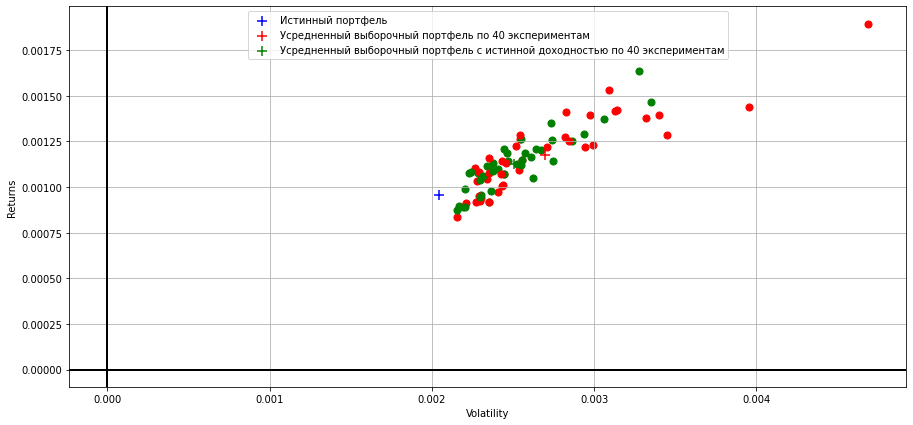

In [31]:
S = 40

# plot
fig, ax = plt.subplots(figsize=(15, 7))
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')
ax.scatter(x_opt_volatility, x_opt_return, color="blue", marker="+", s=100, label="Истинный портфель")      

# main loop
x_opt_list = [] # оптимальные портфели для каждого из S экспериментов 
rel_errors = [] # относительные ошибки
x_opt_40_returns = [] # доходность каждого из S портфелей
x_opt_40_volatilities = [] # риск каждого из S портфелей

x_opt_list_ist = [] # оптимальные портфели для каждого из S экспериментов 
rel_errors_ist = [] # относительные ошибки
x_opt_40_returns_ist = [] # доходность каждого из S портфелей
x_opt_40_volatilities_ist = [] # риск каждого из S портфелей

for i in range(S):
    # random log returns
    log_returns_40 = np.random.multivariate_normal(means.to_numpy(dtype=float).T[0], cov.to_numpy(dtype=float), size=T)
    log_returns_40 = pd.DataFrame(data = log_returns_40, columns=tickers)
    
    # calculate sample means and sample covariance matrix
    means_40 = calc_sample_means(log_returns_40)
    cov_40 = calc_sample_cov(log_returns_40, means_40, verbose=True)
    
    # find optimal portfolio
    x_opt_40, utility_function_40_sample = find_optimal_portfolio(calc_utility_function, 
                                                     (means_40, cov_40, b), 
                                                     n_stocks=means_40.shape[0], 
                                                     decimals=3, 
                                                     short_sales=False)
    x_opt_40_ist, utility_function_40_sample_ist = find_optimal_portfolio(calc_utility_function, 
                                                     (means, cov_40, b), 
                                                     n_stocks=means_40.shape[0], 
                                                     decimals=3, 
                                                     short_sales=False)
    
    # calculate and store the value of error
    rel_errors.append(calc_relative_cityblock_error(x_opt, x_opt_40)) 
    rel_errors_ist.append(calc_relative_cityblock_error(x_opt, x_opt_40_ist)) 
    
    # store return and volatility of an optimal portfolio
    x_opt_40_returns.append(calc_portfolio_return(x_opt_40, means))
    x_opt_40_volatilities.append(calc_portfolio_volatility(x_opt_40, cov))

    x_opt_40_returns_ist.append(calc_portfolio_return(x_opt_40_ist, means))
    x_opt_40_volatilities_ist.append(calc_portfolio_volatility(x_opt_40_ist, cov))
    
    x_opt_list.append(np.array(x_opt_40))
    x_opt_list_ist.append(np.array(x_opt_40_ist))    
    
    # plot
    ax.scatter(x_opt_40_volatilities[i], x_opt_40_returns[i], 
           color="red", marker="o", s=50)
    ax.scatter(x_opt_40_volatilities_ist[i], x_opt_40_returns_ist[i], 
           color="green", marker="o", s=50)
    
x_opt_list = np.array(x_opt_list)
x_opt_list_ist = np.array(x_opt_list_ist)

# plot
ax.scatter(np.array(x_opt_40_volatilities).mean(), np.array(x_opt_40_returns).mean(), 
           color="red", marker="+", s=100, label=f"Усредненный выборочный портфель по {S} экспериментам")
ax.scatter(np.array(x_opt_40_volatilities_ist).mean(), np.array(x_opt_40_returns_ist).mean(), 
           color="green", marker="+", s=100, label=f"Усредненный выборочный портфель c истинной доходностью по {S} экспериментам")

ax.set_xlabel("Volatility")
ax.set_ylabel("Returns")
ax.grid()
ax.legend()
fig.show()

first_error = np.array(rel_errors).mean()
print(f"Средняя относительная ошибка по {S} повторениям эксперимента: {np.array(rel_errors).mean()}")
print(f"Средняя относительная ошибка по {S} повторениям эксперимента для выборочного портфеля с истинной доходностью: {np.array(rel_errors_ist).mean()}")


### Задание 3. Оценка неопределенности оптимального CVaR портфеля 

#### 3.1 
Уровень значимости $β$ выбран $0,95$. Число наблюдений $T$. Используя сгенерированные наблюдения из п.2.1 решите задачу ЛП для определения оптимального $CVaR_β$ портфеля.  Найдите и зафиксируйте веса портфеля и значение целевой функции $CVaR_β$.  

In [32]:
returns30 = log_returns_30.to_numpy() #sample generated in task 2.1
T = returns30.shape[0]
N = returns30.shape[1]
beta = 0.95 #significance level

def obj_func(vec_ut_x_alpha, T, beta):
    return vec_ut_x_alpha[N+T] + 1/(T-T*beta)*np.sum(vec_ut_x_alpha[:T])

def func(vec_ut_x_alpha, returns30, t): #RX + alpha + ut
    RX = np.dot(returns30[t], vec_ut_x_alpha[T:N+T])
    return RX + vec_ut_x_alpha[N+T] + vec_ut_x_alpha[t]

def CVaR_optimization(beta, returns30, func):
    alpha  = 0 
    x = np.ones(N)/N
    ut = - np.dot(returns30,  x) - alpha #dummy variables
    
    vec_ut_x_alpha = np.zeros(N+T+1)
    vec_ut_x_alpha[:T] = ut
    vec_ut_x_alpha[T:N+T] = x
    vec_ut_x_alpha[N+T] = alpha
    
    alpha_bound = ((-inf, inf),)
    x_bound = ((0, 1.1),)*N 
    ut_bound = ((0, inf),)*T 
    
    constraints = list()
    constraints.append({'type': 'eq', 'fun': lambda x: sum(x[T:N+T])-1}) #sum(xi) = 1
    
    for t in range(0, T):
        constraints.append({'type': 'ineq', 'fun': func, 'args': (returns30, t)}) #RX + alpha + ut >= 0

    return minimize(obj_func, vec_ut_x_alpha, args=(T, beta), method='SLSQP', #МНК
                    constraints=constraints, bounds=ut_bound+x_bound+alpha_bound).x

In [33]:
ans = CVaR_optimization(beta, returns30, func)
weights_cvar = ans[T:N+T]
cvar_alpha  = round(ans[N+T], 5)

In [34]:
weights_cvar

array([3.54778423e-02, 5.80474194e-02, 4.02468922e-02, 0.00000000e+00,
       7.36061760e-02, 2.62941710e-02, 2.42208952e-01, 0.00000000e+00,
       6.14304490e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.26418016e-01, 0.00000000e+00, 5.17165331e-02, 1.64055356e-04,
       6.14751456e-02, 0.00000000e+00, 2.22914348e-01, 6.22559135e-16])

In [35]:
print('Alpha полученного CVaR портфеля:' , cvar_alpha)

Alpha полученного CVaR портфеля: -0.00054


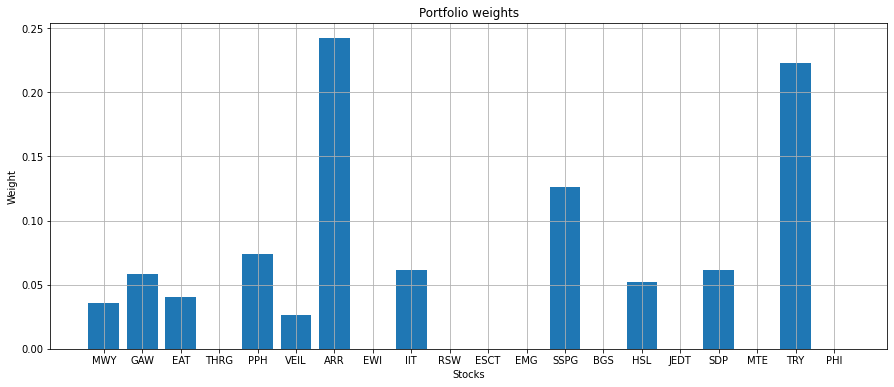

In [36]:
plt.figure(figsize=(15,6))
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.bar(tickers, weights_cvar)
plt.grid()
plt.title('Portfolio weights')
plt.show()

#### 3.2 
Сравните два портфеля: истинный (п.1) и найденный в п.3.1.  Оцените относительную ошибку в определении весов портфеля в норме Manhattan (L1 норма Минковского). Сравните с ошибкой портфеля из п. 2.3

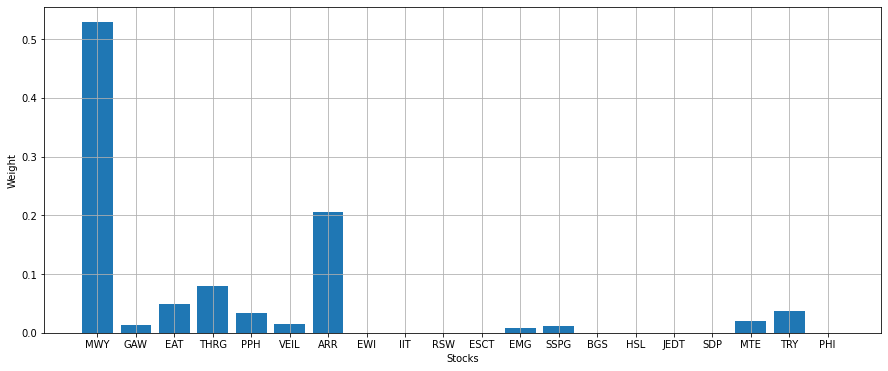

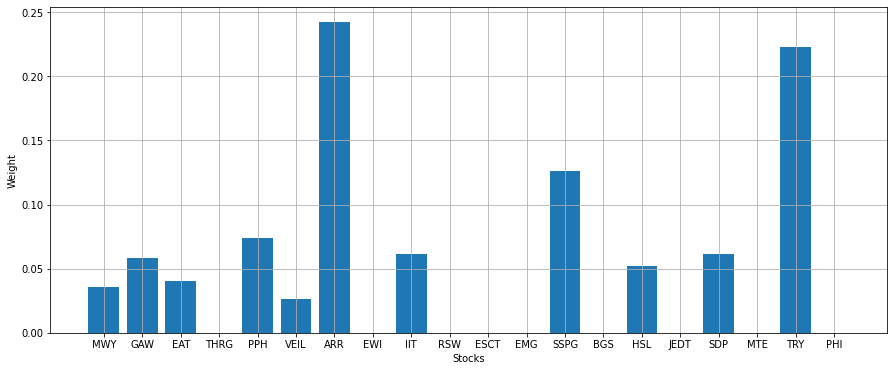

In [37]:
plt.figure(figsize=(15,6))
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.bar(tickers, x_opt)
plt.grid()
plt.show()

plt.figure(figsize=(15,6))
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.bar(tickers, weights_cvar)
plt.grid()
plt.show()

Портфели имеют крайне разное распределение весов. В первом случае большую часть занимает MWY, а во втором - ARR и TRY.

In [38]:
norm1 = calc_relative_cityblock_error(x_opt,  x_opt_30)
norm2 = calc_relative_cityblock_error(x_opt, weights_cvar)

print('Относительная ошибка в норме Manhattan для портфеля из п.2.3 :', norm1)
print('Относительная ошибка в норме Manhattan для портфеля, полученного с помощью CVaR_optimization:', norm2)

Относительная ошибка в норме Manhattan для портфеля из п.2.3 : 1.0969030969030968
Относительная ошибка в норме Manhattan для портфеля, полученного с помощью CVaR_optimization: 1.2183321987114821


#### 3.3
Повторите эксперимент $S$ раз и оцените среднюю относительную ошибку по S повторениям эксперимента. Сделайте выводы.  Сравните с ошибкой из п. 2.5 

20/20
Средняя относительная ошибка по 40 повторениям эксперимента CVaR портфеля: 0.8351648351648352  
Средняя относительная ошибка по 40 повторениям эксперимента из 2.5: 0.747952047952048  


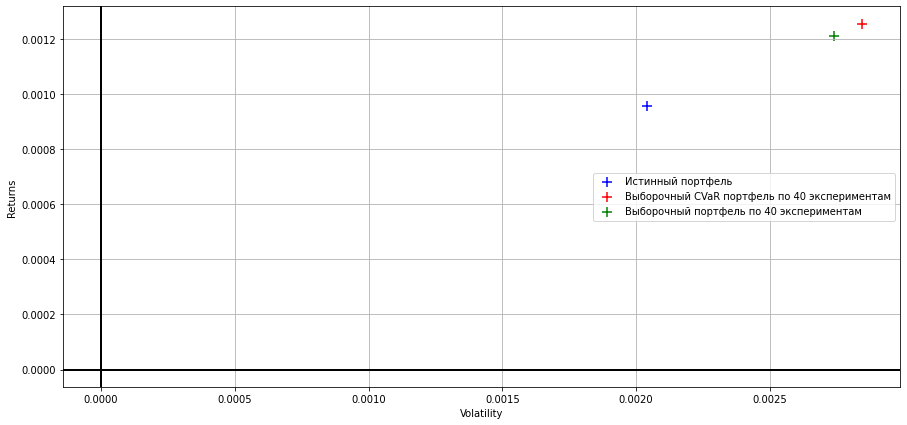

In [39]:
S = 40

# plot
fig, ax = plt.subplots(figsize=(15, 7))
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')
ax.scatter(x_opt_volatility, x_opt_return, color="blue", marker="+", s=100, label="Истинный портфель")      

# main loop
x_opt_list = [] # оптимальные портфели для каждого из S экспериментов 
rel_errors = [] # относительные ошибки
x_opt_40_returns = [] # доходность каждого из S портфелей
x_opt_40_volatilities = [] # риск каждого из S портфелей

x_opt_list_2 = [] # оптимальные портфели для каждого из S экспериментов 
rel_errors_2 = [] # относительные ошибки
x_opt_40_returns_2 = [] # доходность каждого из S портфелей
x_opt_40_volatilities_2 = [] # риск каждого из S портфелей

for i in range(S):
    # random log returns
    log_returns_40 = np.random.multivariate_normal(means.to_numpy(dtype=float).T[0], cov.to_numpy(dtype=float), size=T)
    log_returns_40 = pd.DataFrame(data = log_returns_40, columns=tickers)
    returns30 = log_returns_40.to_numpy()
    ans = CVaR_optimization(beta, returns30, func)
    x_opt_r_sample = ans[T:N+T]
    cvar_alpha  = round(ans[N+T], 5)
    
    # calculate sample means and sample covariance matrix
    means_40 = calc_sample_means(log_returns_40)
    cov_40 = calc_sample_cov(log_returns_40, means_40, verbose=True)
    
    # find optimal portfolio
    x_opt_40_2, utility_function_40_sample_2 = find_optimal_portfolio(calc_utility_function, 
                                                     (means_40, cov_40, b), 
                                                     n_stocks=means_40.shape[0], 
                                                     decimals=3, 
                                                     short_sales=False)
    
    means_40 = calc_sample_means(log_returns_40)
    cov_40 = calc_sample_cov(log_returns_40, means_40, verbose=True)
    
    # calculate and store the value of error
    rel_errors.append(calc_relative_cityblock_error(x_opt, x_opt_40)) 
    rel_errors_2.append(calc_relative_cityblock_error(x_opt, x_opt_40_2)) 
    
    # store return and volatility of an optimal portfolio
    x_opt_40_returns.append(calc_portfolio_return(x_opt_40, means))
    x_opt_40_volatilities.append(calc_portfolio_volatility(x_opt_40, cov))

    x_opt_40_returns_2.append(calc_portfolio_return(x_opt_40_2, means))
    x_opt_40_volatilities_2.append(calc_portfolio_volatility(x_opt_40_2, cov))
    
    x_opt_list.append(np.array(x_opt_40))
    x_opt_list_2.append(np.array(x_opt_40_2))    
    
    # plot
    # ax.scatter(x_opt_40_volatilities[i], x_opt_40_returns[i], 
    #        color="red", marker="o", s=50)
    # ax.scatter(x_opt_40_volatilities_2[i], x_opt_40_returns_2[i], 
    #        color="green", marker="o", s=50)
    
x_opt_list = np.array(x_opt_list)
x_opt_list_2 = np.array(x_opt_list_2)

# plot
ax.scatter(np.array(x_opt_40_volatilities).mean(), np.array(x_opt_40_returns).mean(), 
           color="red", marker="+", s=100, label=f"Выборочный CVaR портфель по {S} экспериментам")
ax.scatter(np.array(x_opt_40_volatilities_2).mean(), np.array(x_opt_40_returns_2).mean(), 
           color="green", marker="+", s=100, label=f"Выборочный портфель по {S} экспериментам")

ax.set_xlabel("Volatility")
ax.set_ylabel("Returns")
ax.grid()
ax.legend()
fig.show()

print(f"Средняя относительная ошибка по {S} повторениям эксперимента CVaR портфеля: {np.array(rel_errors).mean()}  ")
print(f"Средняя относительная ошибка по {S} повторениям эксперимента из 2.5: {np.array(rel_errors_2).mean()}  ")